In [ ]:
# Install PySpark and Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q pyspark findspark

In [ ]:
# get spark
import findspark
findspark.init()

In [ ]:
# Download additional resources for NLP
import nltk
nltk.download('stopwords')
import spacy
spacy.cli.download("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pyspark
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, ArrayType, StringType
from sklearn.feature_extraction.text import CountVectorizer as SklearnCountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stopwords
import pandas as pd
import os
import joblib
import re
import csv

In [ ]:
# Initialize SpaCy for additional stopwords
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Create Spark session
spark = SparkSession \
    .builder \
    .appName("Proj3") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

In [ ]:
# Combine stopwords from all libraries
all_stopwords = set(stopwords.words('english')).union(
    nlp.Defaults.stop_words, gensim_stopwords, sklearn_stopwords)

In [ ]:
# Custom stopword removal function
def remove_stopwords(text):
    words = re.findall(r'\w+', text.lower())
    filtered_words = [word for word in words if word not in all_stopwords]
    return " ".join(filtered_words)

In [ ]:
# Register the stopword removal function as a UDF in Spark
remove_stopwords_udf = F.udf(remove_stopwords, StringType())

In [ ]:
# Read the input data (training, mapping, and testing)
train_dframe = pd.read_csv('/content/train.csv', quoting=csv.QUOTE_NONNUMERIC, on_bad_lines='skip')
map_dframe = pd.read_csv('/content/mapping.csv')


train_data = spark.createDataFrame(train_dframe)
mapping_data = spark.createDataFrame(map_dframe, ['id', 'genre'])




In [ ]:
# Display input data
train_data.show()


+-----------+--------------------+--------------------+--------------------+
|   movie_id|          movie_name|                plot|               genre|
+-----------+--------------------+--------------------+--------------------+
|2.3890098E7|          Taxi Blues|Shlykov, a hard-w...|['World cinema', ...|
|3.1186339E7|    The Hunger Games|The nation of Pan...|['Action/Adventur...|
|2.0663735E7|          Narasimham|Poovalli Induchoo...|['Musical', 'Acti...|
|  2231378.0|  The Lemon Drop Kid|The Lemon Drop Ki...|          ['Comedy']|
|   595909.0|   A Cry in the Dark|Seventh-day Adven...|['Crime Fiction',...|
|  5272176.0|            End Game|The president is ...|['Action/Adventur...|
|  1952976.0|          Dark Water|{{plot}} The film...|['Thriller', 'Dra...|
|2.4225279E7|                Sing|The story begins ...|           ['Drama']|
|  2462689.0|       Meet John Doe|Infuriated at bei...|['Black-and-white...|
|2.0532852E7|Destination Meatball|A line of people ...|['Animation', 'Sh...|

In [ ]:
# Get the genre count
genre_count = mapping_data.count()

In [ ]:
# Apply stopword removal
train_data = train_data.withColumn("cleaned_plot", remove_stopwords_udf(F.col("plot")))

# Tokenize and Remove stopwords using PySpark StopWordsRemover
tokenizer = RegexTokenizer(inputCol="cleaned_plot", outputCol="tokens", pattern="\\W")
train_data = tokenizer.transform(train_data)

# Additional stopwords removal
spark_stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens", stopWords=list(all_stopwords))
train_data = spark_stopwords_remover.transform(train_data)


In [ ]:
# Convert Spark DataFrame to Pandas for further processing
train_data_pd = train_data.select("filtered_tokens", "genre").toPandas()


In [ ]:
# Use CountVectorizer to convert text into a bag-of-words model
vectorizer = SklearnCountVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train_data_pd['filtered_tokens'].apply(lambda x: " ".join(x)))


In [ ]:
# Map genres to integer labels for multi-label classification
genre_to_id = {row['genre']: row['id'] for row in mapping_data.collect()}
train_data_pd['mapped_genres'] = train_data_pd['genre'].apply(lambda x: [genre_to_id[genre] for genre in x.split(", ") if genre in genre_to_id])


mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_data_pd['mapped_genres'])



In [ ]:
# Train and save Naive Bayes models for each genre
model_dir = "nb_models"
os.makedirs(model_dir, exist_ok=True)

for index in range(y_train.shape[1]):
    y_train_genre = y_train[:, index]
    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train_genre)
    joblib.dump(nb_model, f"{model_dir}/nb_model_{index}.pkl")
    print(f"Finished training and saving model for genre {index}")

joblib.dump(vectorizer, "vectorizer.pkl")
vectorizer = joblib.load("vectorizer.pkl")



In [ ]:
# Function to preprocess and predict genres for user input with debugging
def predict_genres(description):
    # Preprocess the input
    description_cleaned = remove_stopwords(description)
    print(f"Cleaned Input Description: {description_cleaned}")

    # Convert input to vectorized format
    X_input = vectorizer.transform([description_cleaned])
    print(f"Vectorized Input Shape: {X_input.shape}")

    predicted_genres = []
    for index in range(y_train.shape[1]):
        # Load the model for the genre
        nb_model = joblib.load(f"{model_dir}/nb_model_{index}.pkl")
        prediction = nb_model.predict(X_input)[0]
        print(f"Model {index} Prediction: {prediction}")

        if prediction == 1:
            # Map the predicted genre ID back to genre name
            predicted_genres.append(id_to_genre[index])

    return predicted_genres

# Test with a sample input
movie_description = input("Enter the movie description (plot): ")
predicted_genres = predict_genres(movie_description)
print(f"Predicted Genres: {predicted_genres}")


In [ ]:
# Get user input for movie description
movie_description = input("Enter the movie description (plot): ")
predicted_genres = predict_genres(movie_description)
print(f"Predicted genres for the movie description: {predicted_genres}")
print("Cleaned and Tokenized Plot:", train_data.select("cleaned_plot").show(5))
print("Predicted Input Description:", description_cleaned)

Enter the movie description (plot): Ninja Resurrection takes place in the Tokugawa era, at a time when Christians in Japan were being persecuted. The leader of the Shimabara Rebellion, Amakusa ShirÅ, hoped to resist the government forces attacking Christians like him but is assassinated. Soon after, Amakusa's restless spirit returns to avenge his fallen comrades and is up to YagyÅ« JÅ«bei Mitsuyoshi to put a stop to the demonic onslaught.  Jubei's Revenge begins a narration of the timepiece explaining the era, the war between toyotomi and tokugawa, the events that led up to the Shimabara rebellion, and a dark satanic prophecy about Shiro. Along with the narration there are Japanese paintings of these events. The first OVA called "The Cant Of Hell" shows a small band of soldiers raiding a village outside of Harano Castle, and smashing a statue of Madonna. All the villagers hide except for a little boy who they shoot. After the soldiers leave to report the Christian rebels to the shogun

In [ ]:
# Install wordcloud if not installed
!pip install wordcloud

In [ ]:
# Import required libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# Load the Naive Bayes model for a specific genre
# Replace 'genre_index' with the index of the genre for which you want the word cloud
genre_index = 0
model_path = f"nb_models/nb_model_{genre_index}.pkl"
nb_model = joblib.load(model_path)

In [ ]:
# Get the feature names (words) and their probabilities from the model
words = vectorizer.get_feature_names_out()
word_probabilities = nb_model.feature_log_prob_[1]  # Log probabilities for the positive class


In [ ]:
# Create a dictionary with words and their associated probabilities
word_prob_dict = {words[i]: word_probabilities[i] for i in range(len(words))}


In [ ]:
# Generate a word cloud using the top 50 words with the highest probabilities
top_50_words = dict(sorted(word_prob_dict.items(), key=lambda item: item[1], reverse=True)[:50])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_50_words)


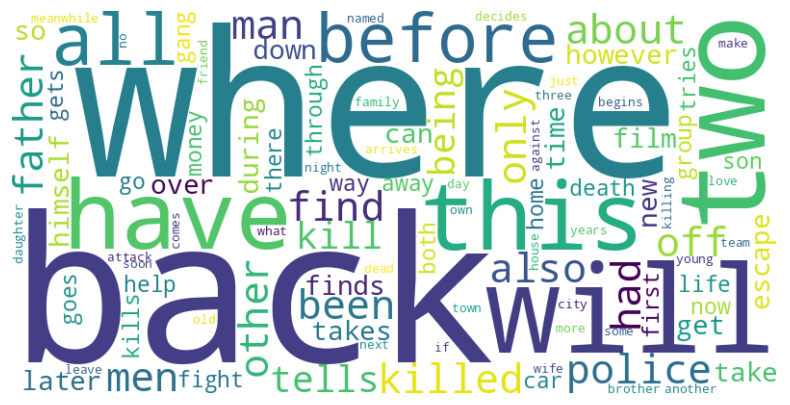

In [ ]:
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()